## Download Audit Opinion set from Audit Analytics data from WRDS

-------------------------

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import wrds
pd.options.display.max_columns=200

-------------

### Connect WRDS

In [2]:
conn=wrds.Connection()

Enter your WRDS username [yjaey]: yjaeyoon
Enter your password: ···············


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
Loading library list...
Done


### Get variable list

In [3]:
auditop_vars= conn.describe_table(library='audit', table='auditopin')['name']
print(len(auditop_vars))

Approximately 343544 rows in audit.auditopin.
225


In [4]:
vars_to_skip= ['matchfy', 'matchqu', 'closestfy', 'closestqu', 'priorqu', 'priorfy', 'note', 'opinion_text', 'eventdate']
for idx, var in enumerate(auditop_vars):
    if any(var_to_skip in var for var_to_skip in vars_to_skip):
        pass
    else:        
        print(idx, var)

0 audit_op_key
1 auditor_affil_fkey
2 auditor_affilname
3 auditor_fkey
4 auditor_name
5 sig_date_of_op_x
6 sig_date_of_op_s
7 going_concern
8 auditor_city
9 auditor_state
10 auditor_state_name
11 auditor_country
12 auditor_region
13 auditor_con_sup_reg
14 fiscal_year_of_op
15 fiscal_year_end_op
16 op_aud_pcaob
17 pcaob_reg_num
23 accnt_basis
24 ftp_file_fkey
25 form_fkey
26 file_date
27 file_accepted
28 file_size
29 http_name_html
30 http_name_text
31 company_fkey
32 best_edgar_ticker


### Select variables to download

In [5]:
vars_to_keep= ['audit_op_key', 'auditor_fkey', 'auditor_name', 'going_concern', 'auditor_country', 
               'fiscal_year_of_op', 'form_fkey', 'company_fkey', 'best_edgar_ticker']

### Pilot check

In [6]:
df_test= conn.get_table(library= 'audit', table='auditopin',
                       columns= vars_to_keep,
                       obs= 3)
df_test

,audit_op_key,auditor_fkey,auditor_name,going_concern,auditor_country,fiscal_year_of_op,form_fkey,company_fkey,best_edgar_ticker
0,66900.0,5.0,Arthur Andersen LLP,0.0,USA,2000.0,10-K,0000000020,None
1,78252.0,5.0,Arthur Andersen LLP,0.0,USA,2001.0,10-K405,0000000020,None
2,3538.0,4.0,KPMG LLP,0.0,USA,2002.0,10-K,0000000020,None


### Download all observations

In [7]:
df= conn.get_table(library= 'audit', table='auditopin',
                       columns= vars_to_keep)
print(df.shape)
df.head()

(343544, 9)


,audit_op_key,auditor_fkey,auditor_name,going_concern,auditor_country,fiscal_year_of_op,form_fkey,company_fkey,best_edgar_ticker
0,66900.0,5.0,Arthur Andersen LLP,0.0,USA,2000.0,10-K,0000000020,None
1,78252.0,5.0,Arthur Andersen LLP,0.0,USA,2001.0,10-K405,0000000020,None
2,3538.0,4.0,KPMG LLP,0.0,USA,2002.0,10-K,0000000020,None
3,39225.0,6.0,Grant Thornton LLP,0.0,USA,2003.0,10-K,0000000020,None
4,84748.0,6.0,Grant Thornton LLP,0.0,USA,2004.0,10-K,0000000020,None


In [8]:
df.rename(columns=
         {'auditor_fkey':'afk',
         'auditor_name':'afn',
         'going_concern':'gco',
         'auditor_country':'af_ctry',
         'fiscal_year_of_op':'fy',
         'company_fkey':'cik',
         'best_edgar_ticker':'tic'}, 
          inplace= True)

In [9]:
df[['audit_op_key', 'fy', 'gco','afk']]= df[['audit_op_key', 'fy', 'gco','afk']].astype('int')

In [10]:
df.groupby(['afn','afk']).count().sort_values('cik', ascending=False).head(10)

,,audit_op_key,gco,af_ctry,fy,form_fkey,cik,tic
afn,afk,,,,,,,
Deloitte & Touche LLP,3,56507,56507,56326,56507,56507,56507,11497
Ernst & Young LLP,2,50808,50808,50627,50808,50808,50808,16659
PricewaterhouseCoopers LLP,1,50565,50565,50247,50565,50565,50565,13439
KPMG LLP,4,36703,36703,36570,36703,36703,36703,11808
Grant Thornton LLP,6,31512,31512,31506,31512,31511,31512,3188
Arthur Andersen LLP,5,6398,6398,6397,6398,6398,6398,901
BDO USA LLP,11761,3137,3137,3132,3137,3137,3137,1939
BDO Seidman LLP,7,2964,2964,2944,2964,2964,2964,675
MaloneBailey LLP,151,2552,2552,2550,2552,2552,2552,1044


In [11]:
df=df[df.fy>=2000]
df=df[df.fy<=2020]
df['big5']= (df['afk']<= 5).astype(int)
print(df.shape)
df.head()

(324416, 10)


,audit_op_key,afk,afn,gco,af_ctry,fy,form_fkey,cik,tic,big5
0,66900,5,Arthur Andersen LLP,0,USA,2000,10-K,0000000020,None,1
1,78252,5,Arthur Andersen LLP,0,USA,2001,10-K405,0000000020,None,1
2,3538,4,KPMG LLP,0,USA,2002,10-K,0000000020,None,1
3,39225,6,Grant Thornton LLP,0,USA,2003,10-K,0000000020,None,0
4,84748,6,Grant Thornton LLP,0,USA,2004,10-K,0000000020,None,0


---------------------

## Check data with visualization

### Distribution by years

<AxesSubplot:xlabel='fy'>

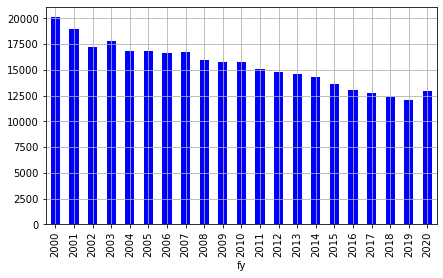

In [12]:
df.groupby(['fy']).count()['cik'].plot(kind='bar', figsize=(7,4), grid= True, color= 'b')

### Proportion (%) of GC firms by years

<AxesSubplot:xlabel='fy'>

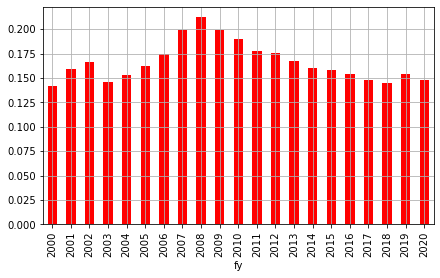

In [13]:
df.groupby(['fy']).mean()['gco'].plot(kind='bar', figsize=(7,4), grid= True, color= 'r')

--------------------

### Save data

In [17]:
df.to_csv('data/aa_auditopin.csv', index= False)
df.head()

,audit_op_key,afk,afn,gco,af_ctry,fy,form_fkey,cik,tic,big5
0,66900,5,Arthur Andersen LLP,0,USA,2000,10-K,0000000020,None,1
1,78252,5,Arthur Andersen LLP,0,USA,2001,10-K405,0000000020,None,1
2,3538,4,KPMG LLP,0,USA,2002,10-K,0000000020,None,1
3,39225,6,Grant Thornton LLP,0,USA,2003,10-K,0000000020,None,0
4,84748,6,Grant Thornton LLP,0,USA,2004,10-K,0000000020,None,0


### Close connection

In [18]:
conn.close()

-------------